In [1]:
from scipy.integrate import RK45, odeint
import numpy as np
import matplotlib.pyplot as plt

# bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider

# Using RK45 - defining what's need to be defined 
[Link RK45 scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html)

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __add__(self, p):
        return Point(self.x+p.x, self.y+p.y)
    
    # not sure this one is useful as it is the same as the previous one
    def __radd__(self, p):
        return Point(self.x+p.x, self.y+p.y)

class Segment:
    def __init__(self,p1,p2):
        self.p1 = p1
        self.p2 = p2
    
    def plot(self):
        plt.plot([self.p1.x, self.p2.x], [self.p1.y, self.p2.y], color='k')

Pour l'instant on suppose les pales comme étant des parallélépipède rectangle de taille $\text{body_radius}\times \text{blade_width}\times \text{blade_thickness}$.

In [3]:
Starship_model1_params = {
    'body_height':0.3, # m
    'nose_cone_height':0.07, 
    'body_radius':0.05, 
    'in_air_vent_surface':0.001, # m2
    'body_density':1200, # kg/m3 
    'body_thickness':0.01,
    'battery_mass':0.3, # kg 
    'computer_mass':0.05, 
    'motor_mass':0.05,
    'blade_thickness':0.002, # m
    'blade_width':0.015,
    'blades_number':3,
    'transmission_axis_radius':0.005,
    'transmission_axis_height':0.3,
    'propellant_system_density':1200,  # kg/m3
    'motor_out_rotation_speed':2000.0, # in turns/min (directly out of the motor here)
}

In [4]:
class Starship_model1:
    debug = False
    CONSTANTS = {
        'air_density' : 1.2, # kg/m3
        'g' : 9.81,
    }
    def __init__(self, body_height, nose_cone_height, body_radius, in_air_vent_surface, \
                 body_density, body_thickness, battery_mass, computer_mass, motor_mass, \
                 blade_thickness, blade_width, blades_number, transmission_axis_radius, \
                 transmission_axis_height, propellant_system_density, motor_out_rotation_speed):
        
        # structural design
        self.body_height = body_height
        self.nose_cone_height = nose_cone_height
        self.body_radius = body_radius # same as nose cone radius
        self.in_air_vent_surface = in_air_vent_surface
        self.body_density = body_density
        self.body_thickness = body_thickness
        
        # other systems
        self.battery_mass = battery_mass
        self.computer_mass = computer_mass
        
        # propellant
        self.motor_mass = motor_mass
        self.blades_number = blades_number
        self.blade_thickness = blade_thickness
        self.blade_width = blade_width
        self.transmission_axis_radius = transmission_axis_radius
        self.transmission_axis_height = transmission_axis_height
        self.propellant_system_density = propellant_system_density
        
        # motor output speed
        self.motor_out_rotation_speed = motor_out_rotation_speed*2.*np.pi/60. # rad/s
        
        # init several quantities of interest
        self.vehicle_mass = self.mass()
        
        # function to compute the speed derivative according to model 1
        # make sure it respects the f(t,y) of scipy RK45
        self.fcn = lambda y, t : self.speed_derivative(y)
        
    def nose_cone_volume(self):
        # ~ max "payload" volume
        # cone
        return np.pi/3.0*self.body_radius*self.nose_cone_height
    
    def body_volume(self):
        # cylinder
        return 2.0*np.pi*self.body_radius*self.body_height
        
    def external_volume(self):
        # total volume of the vehicle
        return self.nose_cone_volume()+self.body_volume()
        
    def structural_volume(self):
        structural_volume = self.body_thickness*(2*np.pi*self.body_radius*\
            (self.body_height+self.nose_cone_height/3.0)-self.in_air_vent_surface)
        return structural_volume
    
    def propeller_volume(self):
        propeller_volume = self.blades_number*self.blade_width*self.blade_thickness\
            *self.body_radius+2*np.pi*self.transmission_axis_radius**2\
            *self.transmission_axis_height
        return propeller_volume
    
    def mass(self):
        total_mass = self.structural_volume()*self.body_density + \
            self.propeller_volume()*self.propellant_system_density + self.battery_mass + \
            self.computer_mass
        
        return total_mass
    
    def plot_vehicle_plane_cut(self):
        points = {
            'P1': Point(0,0),
            'P2': Point(2*self.body_radius,0),
            'P3': Point(0,self.body_height),
            'P4': Point(2*self.body_radius,self.body_height),
            'P5': Point(self.body_radius,self.body_height+self.nose_cone_height),
            'P6': Point(self.body_radius-self.transmission_axis_radius,0),
            'P7': Point(self.body_radius+self.transmission_axis_radius,0),
            'P8': Point(self.body_radius-self.transmission_axis_radius,\
                  self.transmission_axis_height),
            'P9': Point(self.body_radius+self.transmission_axis_radius,\
                  self.transmission_axis_height),
        }
        segments = [
           Segment(points['P1'], points['P2']),
           Segment(points['P1'], points['P3']),
           Segment(points['P2'], points['P4']),
           Segment(points['P3'], points['P5']),
           Segment(points['P4'], points['P5']),
           Segment(points['P6'], points['P7']),
           Segment(points['P6'], points['P8']),
           Segment(points['P7'], points['P9']),
           Segment(points['P8'], points['P9']),
        ]

        fig, ax = plt.subplots()
        for segment in segments:
            segment.plot()
        ax.axis('equal')
        plt.show()
        
    def gaz_ejection_speed(self, v):
        # speed of the air expulsed by the 'rocket'
        u = 2*self.body_radius*self.motor_out_rotation_speed - v
        if(self.debug):print('Ejection speed of gaz : {:e}'.format(u))
        return u
    
    def gaz_ejection_speed_2(self, v):
        # speed of the air expulsed by the 'rocket'
        constant = 2*Dm*R/(self.)
        u = np.sqrt(self.motor_out_rotation_speed)
        if(self.debug):print('Ejection speed of gaz : {:e}'.format(u))
        return u
    
    def speed_derivative(self, v, model = 1):
        if(model == 1):
            u = self.gaz_ejection_speed(v, model)
            S = np.pi*self.body_radius*self.body_radius
            v_der_ = self.CONSTANTS['air_density']/self.vehicle_mass*\
                (S*u*u-self.in_air_vent_surface*v*v)-self.CONSTANTS['g']
            if(self.debug):
                print('Derivative of v : {}'.format(v_red_))
            return v_der_
        elif(model == 2):
            u = self.gaz_ejection_speed_2(v, model)
            S = np.pi*self.body_radius*self.body_radius
            v_der_ = self.CONSTANTS['air_density']/self.vehicle_mass*\
                (S*u*u-self.in_air_vent_surface*v*v)-self.CONSTANTS['g']
            if(self.debug):
                print('Derivative of v : {}'.format(v_red_))
            return v_der_
    
    
    # max_speed is false here...
    def max_speed(self, mass = None, omega = None):
        if(mass==None):
            mass = self.vehicle_mass
        if(omega==None):
            omega = self.motor_out_rotation_speed
        else:
            omega = omega*2*np.pi/60.0
        # to plot as a function of the mass here.
        # or motor_out_rotation_speed
        S = np.pi*self.body_radius*self.body_radius
        Se = self.in_air_vent_surface
        g, rho_air = self.CONSTANTS['g'], self.CONSTANTS['air_density']
        R = self.body_radius
        
        # coefficients of the quadratic equation to solve, here 2D.
        p = np.array([Se*(Se/S-1), -4*R*Se*omega, 4*R*R*omega*omega*S-g*mass/rho_air])
        # see https://numpy.org/doc/stable/reference/generated/numpy.roots.html
        roots = np.roots(p) # 2 solutions max
        # we'll select, for now, the bigger one 
        # and only if it's higher than 0
        real_roots = [root for root in roots if (np.imag(root)==0. or np.imag(root)==0)]
        vlim = max(real_roots) if (len(real_roots)>0) else 0.
        vlim = max(0.0, vlim)
        return vlim
        
    def positions(self, z0, speed_evolution, time_step):
        # speed_evolution is an ndarray
        z = np.zeros(speed_evolution.shape)
        z[0] = z0
        for idx, speed in np.ndenumerate(speed_evolution[1:]):
            z[idx[0]+1] = z[idx[0]] + time_step*speed
        return z

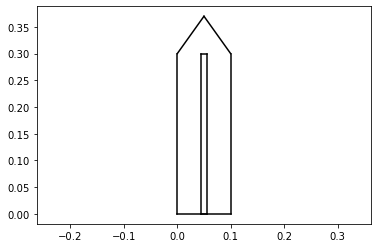

Vehicle mass : 1.618887e+00 kg


In [5]:
model = Starship_model1(**Starship_model1_params)
model.plot_vehicle_plane_cut()
print('Vehicle mass : {:e} kg'.format(model.vehicle_mass))

In [6]:
def plot_solution():

    model = Starship_model1(**Starship_model1_params)
    fcn = model.fcn
    
    tini = 0.
    tend = 20.
    max_step = 1000

    t = np.linspace(tini,tend,max_step)
    step = (tend-tini)/max_step
    
    yini = 0.0 # init speed
    
    rtol, atol = 1e-3, 1e-6 # default values

    sol = odeint(func = fcn, t = t, y0 = yini)[:,0]

    pos = model.positions(yini, sol, step)

    fig_sol_speed = figure(x_range=(tini, tend), plot_height=450, plot_width=900, title="Speed")
    plt_sol_v = fig_sol_speed.x(t, sol, line_width=2) # legend_label="Speed")
    
    fig_sol_pos = figure(x_range=(tini, tend), plot_height=450, plot_width=900, title="Positions")
    plt_sol_pos = fig_sol_pos.x(t, pos, line_width=2) # legend_label="Altitude")

    #show(column(fig_sol_speed), notebook_handle=True)

    show(column(fig_sol_speed,fig_sol_pos), notebook_handle=True)
    
    def update(omega, mass):
        model.motor_out_rotation_speed = omega*2*np.pi/60.0
        model.vehicle_mass = mass

        fcn = model.fcn
        
        sol = odeint(func = fcn, t = t, y0 = yini)[:,0]
        pos = model.positions(yini, sol, step)

        plt_sol_v.data_source.data = dict(x=t, y=sol)
        plt_sol_pos.data_source.data = dict(x=t, y=pos)

        push_notebook()

    w=interact(update,
               mass=FloatSlider(min=0.01, max=2.0, value=model.vehicle_mass, step=0.01, continuous_update=False, description='mass (kg)'),
              omega=FloatSlider(min=0.01, max=10000.0, value=Starship_model1_params['motor_out_rotation_speed'], \
                                        step=1, continuous_update=False, description='$\omega$ (rpm)')
              )

In [7]:
plot_solution()

interactive(children=(FloatSlider(value=2000.0, continuous_update=False, description='$\\omega$ (rpm)', max=10…

In [8]:
def plot_vlim():

    model = Starship_model1(**Starship_model1_params)
    fcn = model.fcn
    
    nt = 100
    omega_min, omega_max = 1000, 10000
    mass_min, mass_max = 0.01, 5
    omega_array = np.linspace(omega_min, omega_max, nt)
    mass_array = np.linspace(mass_min, mass_max, nt)
    
    v_lim_omega = np.array([model.max_speed(omega=omega) for omega in omega_array])
    v_lim_mass = np.array([model.max_speed(mass=mass) for mass in mass_array])
    
    fig_max_speed_mass = figure(x_range=(mass_min, mass_max), plot_height=450, plot_width=900, title="Max speed as a function of mass (kg)")
    plt_sol_mass = fig_max_speed_mass.x(mass_array, v_lim_mass, line_width=2)
    
    fig_max_speed_omega = figure(x_range=(omega_min, omega_max), plot_height=450, plot_width=900, title="Max speed as a function of omega (turn/min)")
    plt_sol_omega = fig_max_speed_omega.x(omega_array, v_lim_omega, line_width=2)

    xx, yy = np.meshgrid(omega_array, mass_array)
    
    zz = np.zeros((len(xx), len(yy)))
    for i in range(len(xx)):
        for j in range(len(yy)):
            # treat xx[i,j], yy[i,j]
            zz[i,j] = model.max_speed(omega = xx[i,j], mass = yy[i,j])
            if(zz[i,j]<0):
                print(zz[i,j])
    
    fig_color_map = figure(plot_width=900, plot_height=450, tooltips=[("omega", "$x"), ("mass", "$y"), ("max speed", "@image")])
    fig_color_map.x_range.range_padding = fig_color_map.y_range.range_padding = 0

    fig_color_map.image(image=[zz], x=omega_min, y=mass_min, dw=omega_max, dh=mass_max, palette="Spectral11", level="image")
    fig_color_map.grid.grid_line_width = 0.5

    #show(column(fig_max_speed_mass,fig_max_speed_omega, fig_color_map), notebook_handle=True)
    show(fig_color_map, notebook_handle=True)
plot_vlim()